In [1]:
import pandas as pd 
import numpy as np 
import pingouin as pg 
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# read in the metric files saved as csv
controls = pd.read_csv('../../DerivedData/extracted_diffusion_metrics_control_group_mergedLR.csv', index_col=0)
preterms = pd.read_csv('../../DerivedData/extracted_diffusion_metrics_preterm_group_mergedLR.csv', index_col=0)

### create pairing - as there is fewer preterms, use their IDs to find matches with controls 
matched = pd.read_csv('../../DerivedData/subject_matching.csv', index_col=0)
matched = matched[matched['preterm_ID'].isin(preterms['subject_id'].values)]

#get matched controls
controls = controls[controls.subject_id.isin(matched.matched_ID_with_outcome.values)]

### concatenate the two 
df = pd.concat([preterms, controls])

# Clinical variables 
clinic = pd.read_csv('../../DerivedData/Global.csv', sep=';')
to_keep = ['ParticipantID', 'FetalGrowthRestriction', 'ParenteralNutrition>21d', 'Pregnancy-size', 
          'Sex', 'Gabirth', 'PMA-MRI']
clinic = clinic[to_keep]
clinic.rename( columns ={
                'ParticipantID' : 'subject_id',
                'ParenteralNutrition>21d' : 'ParenteralNutrition',
                'Pregnancy-size' : 'PregnancySize', 
                'Gabirth' : 'birth_age',
                'PMA-MRI' : 'scan_age'
                }, inplace=True)


df = pd.merge(df, clinic, how="outer", on=["subject_id"])

for col in ['birth_age', 'scan_age']:
        df[col] = df[col].astype(str)
        df[col] = df[col].apply(lambda x: x.replace(',','.'))
        df[col] = df[col].astype(np.float16)

### categorize what needs to be categorized

for col in ['ParenteralNutrition','PregnancySize', 'FetalGrowthRestriction', 'Sex']:
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.codes

    
### multiply the diffusivities by 1000    

#for col in df.columns:
#    if 'AD' in col or 'RD' in col or 'MD' in col:
#        df[col] = df[col] * 1000

###
# compute residual WM 
## need mean WM ~ PMA-MRI

ex_WM = pd.read_csv('../../DerivedData/extreme_pairs_mean_diffusion_metrics_over_WM.csv', index_col=0)
mod_WM = pd.read_csv('../../DerivedData/moderate_pairs_mean_diffusion_metrics_over_WM.csv', index_col=0)

WM = pd.concat([ex_WM, mod_WM])
WM.rename(columns={'matched_ID' : 'control_ID'}, inplace=True)

preterm_cols = [col for col in WM.columns if 'preterm' in col]
preterm_cols = [col for col in preterm_cols if 'post' not in col]
matched_cols = [col for col in WM.columns if 'control' in col]
matched_cols = [col for col in matched_cols  if 'post' not in col]

pt = WM[preterm_cols].copy()
mt = WM[matched_cols].copy()

pt = pt.set_axis([col.split('_')[1] for col in preterm_cols] , axis=1, inplace=False)
mt = mt.set_axis([col.split('_')[1] for col in matched_cols] , axis=1, inplace=False)

pt.reset_index(drop=True, inplace=True)
mt.reset_index(drop=True, inplace=True)

#del WM

new_WM = pt.copy()
new_WM = new_WM.append(mt.copy())

new_WM = new_WM.set_axis(['meanWM_' + col for col in pt.columns] , axis=1, inplace=False)
new_WM.rename(columns={'meanWM_ID': 'subject_id'}, inplace =True)

df = pd.merge(df, new_WM, how="outer", on=["subject_id"])

for metric in ['AD', 'RD', 'FA', 'MD', 'NDI', 'ODI']:

    #df['residual_'+metric] = get_residuals(global_WM = np.float32(df['meanWM_' + metric].values), 
                                           #scan_age = np.float32(df['scan_age'].values), 
                                          #birth_age = np.float32(df['birth_age'].values))
    
    df['residual_'+metric] = get_residuals(metric=metric, df=df)



In [233]:
### test the same while multiplying residuals for diffusiviteis by 1000 (like in A2 models)
# this sanity check worked, the results are the same, thank gods!
#for metric in ['AD', 'RD', 'MD']:   
    #df['residual_'+metric] = df['residual_'+metric].values * 1000

In [3]:
def get_residuals(metric, df):
    from pingouin import linear_regression
    
    df = df.copy()
    
    df['scan_age'] = np.float32(df['scan_age'].values)
    df['birth_age'] = np.float32(df['birth_age'].values)
    df['meanWM_' + metric] = np.float32(df['meanWM_' + metric].values)
    
    lm = linear_regression( X= df[['scan_age', 'birth_age']], y = df['meanWM_' + metric])
    #lm = linear_regression( X= df['scan_age'], y = df['meanWM_' + metric])
    return lm.residuals_

#def get_residuals(global_WM, scan_age, birth_age):
    
#    from pingouin import linear_regression
    
#    lm = linear_regression( X= [scan_age, birth_age], y = global_WM)
#    return lm.residuals_

In [5]:
## to fix the ordering for plots 
pair_names = [
    'M1-Brainstem', 'S1-Brainstem','Paracentral-Brainstem',
    'M1-Caud', 'S1-Caud','Paracentral-Caud',
    'M1-Lenti', 'S1-Lenti','Paracentral-Lenti', 
    'M1-Thalfus', 'S1-Thalfus','Paracentral-Thalfus', 
    'M1L-M1R', 'S1L-S1R',
    'S1-M1' ]

In [6]:
results = pd.DataFrame()
results_T = pd.DataFrame()
after_correction = pd.DataFrame()
after_correction['birth_age'] = df['birth_age']

for i, metric in enumerate(['AD', 'RD', 'FA', 'MD', 'NDI', 'ODI']):
    metric_subset = [tract + '_' + metric for tract in pair_names]
    
    results.loc[i, 'metric'] = metric
    results_T.loc[i, 'metric'] = metric
    

    for bundle in metric_subset: 
        #print(bundle)
        
        #correction = pg.linear_regression(X = df[[ 'scan_age', 'residual_'+metric, 'FetalGrowthRestriction' ]], y = df[bundle])
        correction = pg.linear_regression(X = df[[ 'scan_age', 'residual_'+metric ]], y = df[bundle])
        #correction = pg.linear_regression(X = df[[ 'scan_age', 'FetalGrowthRestriction' ]], y = df[bundle])
        res = correction.residuals_
        
        after_correction[bundle] = res
        
        test= pg.linear_regression(X = df['birth_age'], y = res)
    
        new_col = bundle.split('_')[0]
        
        results.loc[i, new_col+'_p'] = np.float64(test['pval'][1])
        results_T.loc[i, new_col+'_T'] = np.round(np.float64(test['T'][1]),2)
        results_T.loc[i, new_col+'_slope'] = np.round(np.float64(test['coef'][1]),5)

        
results[results.columns[1:]] = results[results.columns[1:]].astype(np.float64)

pre_p = results[results.columns[1:]].values.ravel()
reject, pvals_corr = pg.multicomp(pre_p, method='fdr_bh')
pvals_corr = pvals_corr.reshape(np.shape(results[results.columns[1:]].values))

results[results.columns[1:]] = pvals_corr


In [7]:
combined = pd.merge(results, results_T , on='metric', how='outer').T

new_header = combined.iloc[0].values
#for value in  combined.iloc[0].values:
#    new_header.append(value)
    
combined = combined[1:]
combined.columns = new_header


combined = combined.sort_index()
combined.reset_index(level=0, inplace=True)

combined['grouping'] = [val.split('_')[0] for val in combined['index'].values]
combined['index'] = [val.split('_')[1] for val in combined['index'].values]

combined = combined.pivot_table(values=['AD','RD','FA','MD','NDI','ODI'], index='grouping', columns='index')

In [8]:
#combined.to_csv('linear_regression_univariate_full_results.csv')

In [9]:
#results.T.to_csv('univarite_linear_regression_p.csv')
#results_T.T.to_csv('univarite_linear_regression_T.csv')

In [11]:
colors = {'Brainstem' : 'chocolate',
          'Caud' : 'm', 
          'Lenti': 'lawngreen', 
            'Thalfus': 'deepskyblue', 
          'M1R' : 'darkolivegreen', 
          'S1R' : 'thistle',
          'M1': 'dimgrey' }

In [21]:
def get_notation(value):
        
    if value <= 0.0001:
            notation = '****'
            
    elif 0.0001 < value <= 0.001:
            notation = '***'
            
    elif 0.001 < value <= 0.01:
            notation = '**'
            
    elif 0.01 < value <= 0.05:
            notation ='*'  
        
    elif 0.05 < value <= 0.1:
            notation ='.' 
    else:
            notation = ' '
    return notation
    

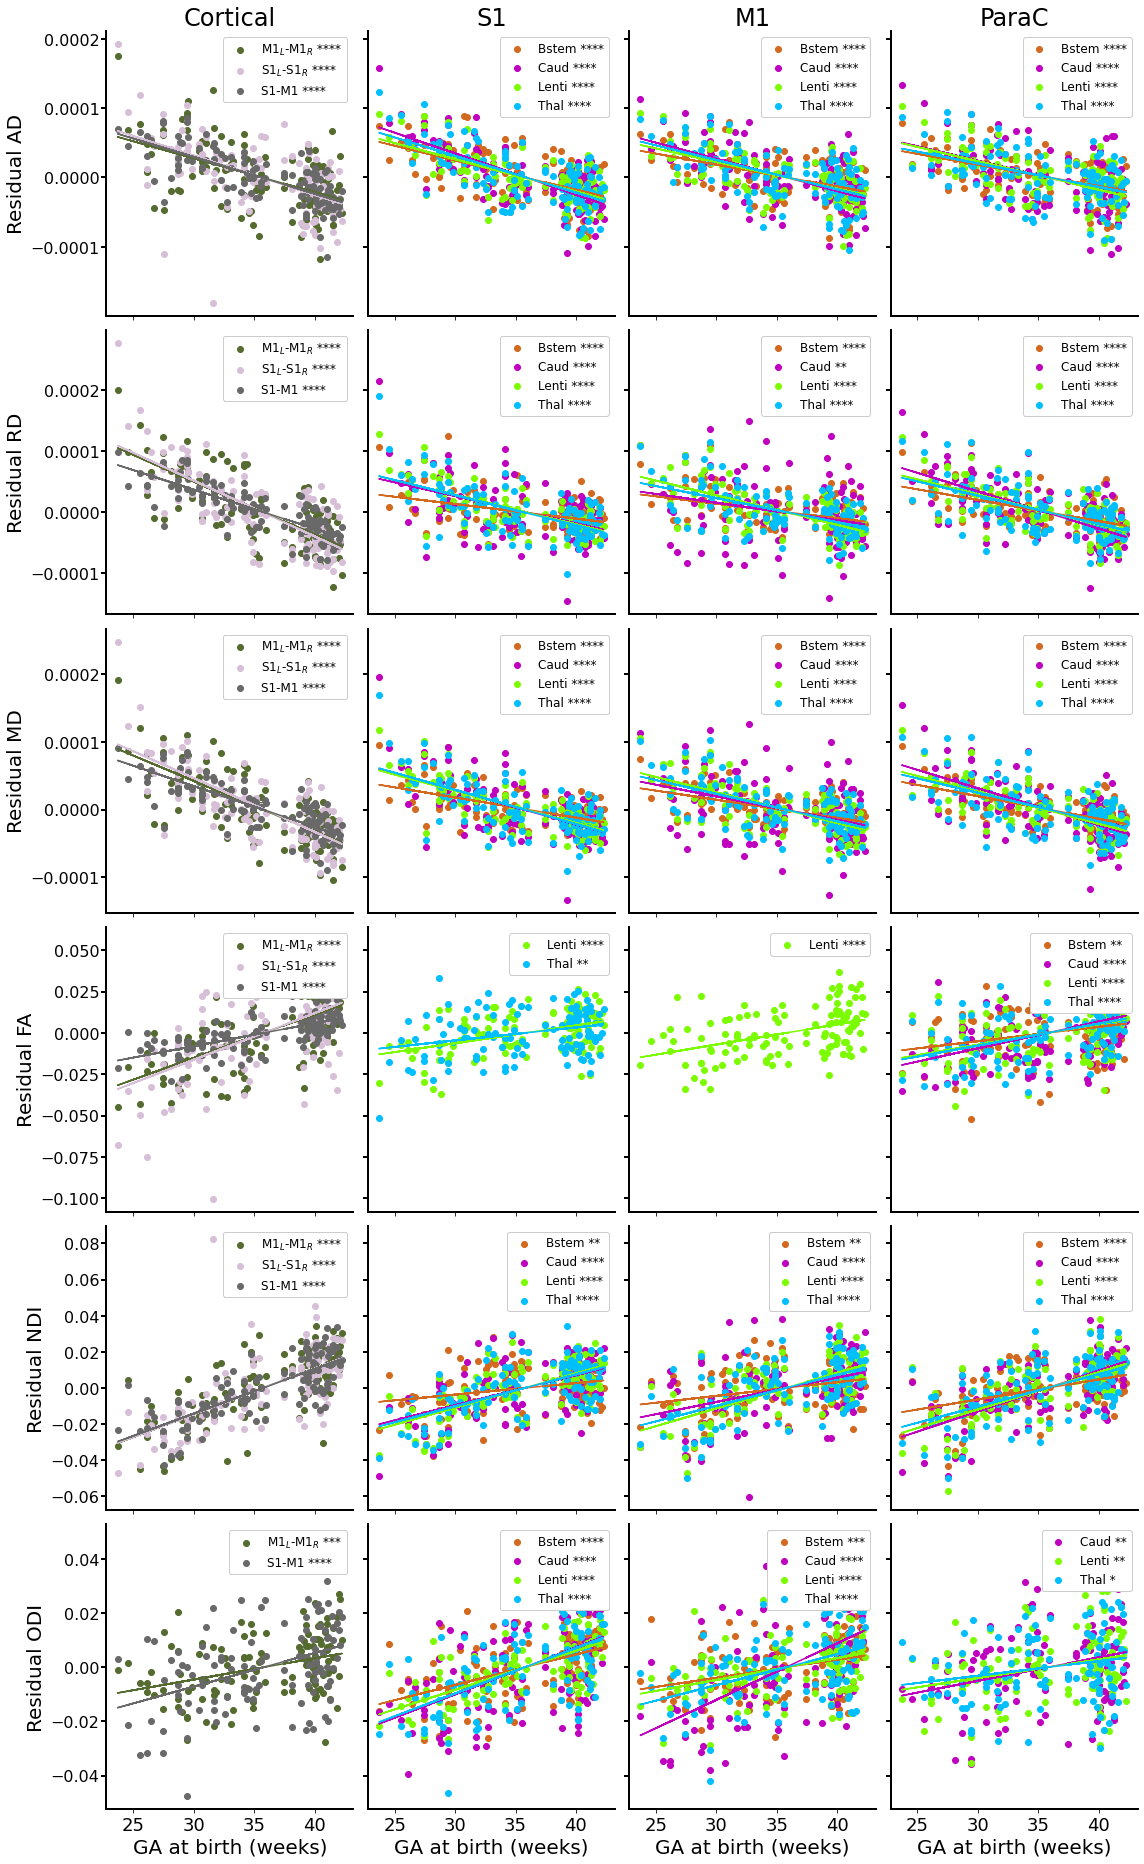

In [50]:
fig, axs = plt.subplots(6,4, figsize=(16,26), sharex=True, sharey='row')

for i,  metric in enumerate(['AD', 'RD', 'MD', 'FA', 'NDI', 'ODI']):
    
    for bundle in after_correction.columns:
        if metric in bundle:
           
            name = bundle.split('_')[0]
            #print(name)
            
            if  name in ['M1L-M1R', 'S1-M1','S1L-S1R']:
                
                ax_idx = 0
                if name == 'S1-M1':
                    label = name 
            
                elif name == 'S1L-S1R':
                    label = 'S1$_L$-S1$_R$'
                    
                    
                else: 
                    label = 'M1$_L$-M1$_R$'

                    
                if results[results.metric == metric][name+'_p'].values[0] < 0.05:
                    
                    value = get_notation(results[results.metric == metric][name+'_p'].values[0])
                    
                    m, b = np.polyfit(np.float32(after_correction['birth_age'].values), np.float32(after_correction[bundle].values), 1)
                    axs[i,ax_idx].plot(after_correction['birth_age'].values, 
                                  m* after_correction['birth_age'].values + b, 
                                 c = colors[name.split('-')[1]])
                    
                 
                    
                    axs[i,ax_idx].scatter(after_correction['birth_age'].values, after_correction[bundle].values,
                                 label=label+' {}'.format(value), c = colors[name.split('-')[1]])
                    axs[i,ax_idx].legend(loc='upper right',framealpha=1, facecolor='white', prop={'size': 12})#, bbox_to_anchor=(1.5, 0.5))
                    axs[i,0].set_ylabel('Residual {}'.format(metric), fontsize=20)
            
            
            if  name in ['M1-Brainstem', 'M1-Thalfus', 'M1-Caud', 'M1-Lenti']:
                
                ax_idx = 2
            
                if name == 'M1-Brainstem':
                    label = 'Bstem' 
                elif name == 'M1-Thalfus':
                    label = 'Thal'
                else: 
                    label = name.split('-')[1] 
                    
                    
                if results[results.metric == metric][name+'_p'].values[0] < 0.05:
                    
                    value = get_notation(results[results.metric == metric][name+'_p'].values[0])
                    
                    m, b = np.polyfit(np.float32(after_correction['birth_age'].values), np.float32(after_correction[bundle].values), 1)
                    axs[i,ax_idx].plot(after_correction['birth_age'].values, 
                                  m* after_correction['birth_age'].values + b, 
                                 c = colors[name.split('-')[1]])
                    
                 
                    
                    axs[i,ax_idx].scatter(after_correction['birth_age'].values, after_correction[bundle].values,
                                 label=label+' {}'.format(value), c = colors[name.split('-')[1]])
                    axs[i,ax_idx].legend(loc='upper right',framealpha=1, facecolor='white', prop={'size': 12})#, bbox_to_anchor=(1.5, 0.5))
                    axs[i,0].set_ylabel('Residual {}'.format(metric), fontsize=20)
                
            if name in ['S1-Brainstem','S1-Thalfus', 'S1-Caud', 'S1-Lenti']: 
                ax_idx = 1
           
                if name == 'S1-Brainstem':
                    label = 'Bstem' 
                elif name == 'S1-Thalfus':
                    label = 'Thal'
                else: 
                    label = name.split('-')[1] 
                    
                    
                if results[results.metric == metric][name+'_p'].values[0] < 0.05:
                    value = get_notation(results[results.metric == metric][name+'_p'].values[0])
                    m, b = np.polyfit(np.float32(after_correction['birth_age'].values), np.float32(after_correction[bundle].values), 1)
                    axs[i,ax_idx].plot(after_correction['birth_age'].values, 
                                  m* after_correction['birth_age'].values + b, 
                                 c = colors[name.split('-')[1]])
                    
                 
                    
                    axs[i,ax_idx].scatter(after_correction['birth_age'].values, after_correction[bundle].values,
                                 label=label+' {}'.format(value), c = colors[name.split('-')[1]])
                    axs[i,ax_idx].legend(loc='upper right',framealpha=1, facecolor='white', prop={'size': 12})#, bbox_to_anchor=(1.5, 0.5))
                    axs[i,0].set_ylabel('Residual {}'.format(metric), fontsize=20)
                
            elif name in ['Paracentral-Brainstem','Paracentral-Thalfus', 'Paracentral-Caud', 'Paracentral-Lenti']: 
                ax_idx = 3
                if name == 'Paracentral-Brainstem':
                    label = 'Bstem' 
                elif name == 'Paracentral-Thalfus':
                    label = 'Thal'
                else: 
                    label = name.split('-')[1] 
                    
            

        
                if results[results.metric == metric][name+'_p'].values[0] < 0.05:
                    value = get_notation(results[results.metric == metric][name+'_p'].values[0])
                    m, b = np.polyfit(np.float32(after_correction['birth_age'].values), np.float32(after_correction[bundle].values), 1)
                    axs[i,ax_idx].plot(after_correction['birth_age'].values, 
                                  m* after_correction['birth_age'].values + b, 
                                 c = colors[name.split('-')[1]])
                    
                 
                    
                    axs[i,ax_idx].scatter(after_correction['birth_age'].values, after_correction[bundle].values,
                                 label=label+' {}'.format(value), c = colors[name.split('-')[1]])
                    axs[i,ax_idx].legend(loc='upper right',facecolor='white',framealpha=1, prop={'size': 12})
                    axs[i,0].set_ylabel('Residual {}'.format(metric), fontsize=20)
              
               
for i in range(4):
    axs[5,i].set_xlabel('GA at birth (weeks)', fontsize=20)
    axs[5,i].tick_params(axis='both', which='major', labelsize=18)

axs[0,0].set_title('Cortical', fontsize=24)
axs[0,1].set_title('S1', fontsize=24)
axs[0,2].set_title('M1', fontsize=24)
axs[0,3].set_title('ParaC', fontsize=24)

fig.patch.set_facecolor('white')

#axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), 
#           ncol = 4, fontsize=18, frameon=False, markerscale=0.6)   

for i in range(6):
    for j in range(4):
        # Hide the right and top spines
        axs[i,j].spines['right'].set_visible(False)
        axs[i,j].spines['top'].set_visible(False)
        for axis in ['bottom','left']:
            axs[i,j].spines[axis].set_linewidth(2)
        
        axs[i,j].tick_params(axis='y', labelsize=16)    
        plt.setp(axs[i,j].yaxis.get_ticklines(), 'markeredgewidth', 2)
        plt.setp(axs[i,j].yaxis.get_ticklines(), 'markersize', 5)

    
plt.tight_layout(pad=1.08) 
plt.savefig('../../Results/figures/univariate_linear_regression_lowres.png', dpi=300,  bbox_inches="tight" )
plt.show()